In [1]:
using Distributions
using HypothesisTests
using Roots
using StatsPlots
default(fmt=:png)

x ⪅ y = x < y || x ≈ y
safediv(x, y) = x == 0 ? zero(x/y) : x/y

function pvalue_sterne(x, n, p)
    bin = Binomial(n, p)
    sum(pdf(bin, i) for i in support(bin) if pdf(bin, i) ⪅ pdf(bin, x))
end

function pvalue_score(x, n, p)
    bin = Binomial(n, p)
    z = safediv(x - mean(bin), std(bin))
    2ccdf(Normal(), abs(z))
end

function posterior_bin(x, n; prior=Beta(1, 1))
    a, b = params(prior)
    Beta(a+x, b+n-x)
end

function pvalue_bayes_eti(x, n, p; prior=Beta(1/3, 1/3))
    posterior = posterior_bin(x, n; prior)
    min(1, 2cdf(posterior, p), 2ccdf(posterior, p))
end

function pvalue_hdi(dist::ContinuousUnivariateDistribution, x₀; xlim = extrema(dist))
    p₀ = pdf(dist, x₀)
    xmode = mode(dist)
    f(x) = pdf(dist, x) - p₀
    if x₀ == xmode
        1.0
    elseif x₀ > xmode
        x₁ = find_zero(f, (xlim[begin], xmode))
        cdf(dist, x₁) + ccdf(dist, x₀)
    else
        x₁ = find_zero(f, (xmode, xlim[end]))
        cdf(dist, x₀) + ccdf(dist, x₁)
    end
end

function pvalue_bayes_hdi(x, n, p; prior=Beta(1, 1))
    posterior = posterior_bin(x, n; prior)
    a, b = params(posterior)
    if a == 1 && b == 1
        1.0
    elseif a ≤ 1
        ccdf(posterior, p)
    elseif b ≤ 1
        cdf(posterior, p)
    else
        pvalue_hdi(posterior, p)
    end
end

pvalue_bayes_hdi (generic function with 1 method)

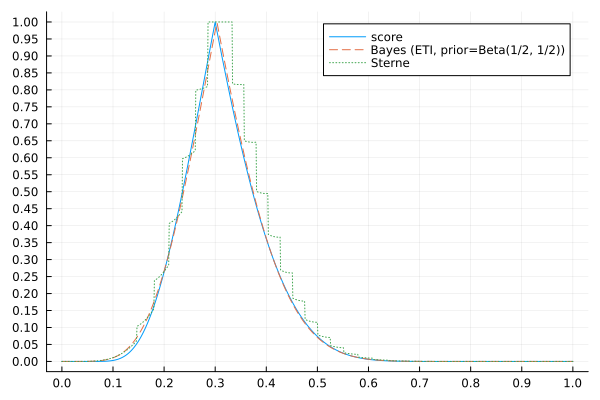

In [2]:
x, n = 6, 20
ps = 0:0.001:1
plot(ps, p -> pvalue_score(x, n, p); label="score")
plot!(ps, p -> pvalue_bayes_eti(x, n, p; prior=Beta(1/2, 1/2));
    label="Bayes (ETI, prior=Beta(1/2, 1/2))", ls=:dash)
plot!(ps, p -> pvalue_sterne(x, n, p); label="Sterne", ls=:dot)
plot!(xtick=0:0.1:1, ytick=0:0.05:1)

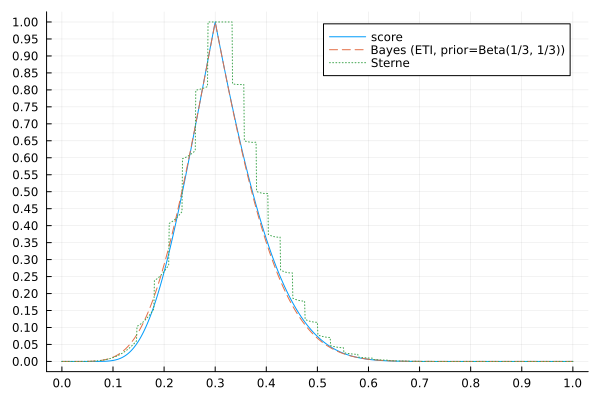

In [3]:
x, n = 6, 20
ps = 0:0.001:1
plot(ps, p -> pvalue_score(x, n, p); label="score")
plot!(ps, p -> pvalue_bayes_eti(x, n, p; prior=Beta(1/3, 1/3));
    label="Bayes (ETI, prior=Beta(1/3, 1/3))", ls=:dash)
plot!(ps, p -> pvalue_sterne(x, n, p); label="Sterne", ls=:dot)
plot!(xtick=0:0.1:1, ytick=0:0.05:1)

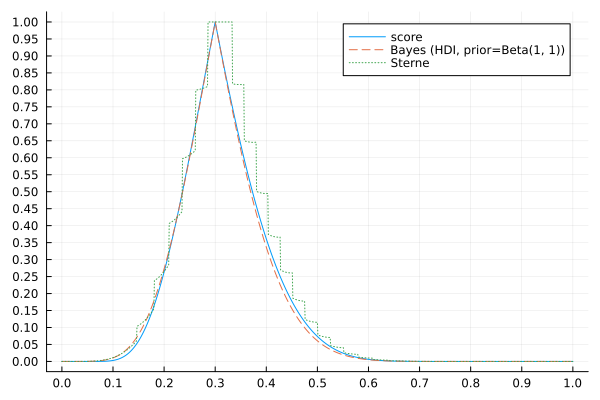

In [4]:
x, n = 6, 20
ps = 0:0.001:1
plot(ps, p -> pvalue_score(x, n, p); label="score")
plot!(ps, p -> pvalue_bayes_hdi(x, n, p; prior=Beta(1, 1));
    label="Bayes (HDI, prior=Beta(1, 1))", ls=:dash)
plot!(ps, p -> pvalue_sterne(x, n, p); label="Sterne", ls=:dot)
plot!(xtick=0:0.1:1, ytick=0:0.05:1)